In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from utils.character_attributes_extraction import attributes2vec, word2vec

/home/cat/EPFL/Fall 2023/ADA/project_repo/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
characters =  pd.read_csv(
    'data/character_attributes_lemmatized.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )
characters.head()

,wiki_id,character,adj,active,patient
0,31186339,Snow,[],"[summon, consider]",[]
1,31186339,Haymitch Abernathy,[],[warn],[]
2,31186339,Seneca Crane,[gamemaker],"[change, lock]","[summon, convince]"
3,31186339,Rue,[die],"[draw, care, draw, trap]","[hear, stab, comfort, kill]"
4,31186339,Primrose Everdeen,[old],[choose],[]


In [5]:
def len_attr(x):
    a = len(x['adj'])
    if x['adj'][0] == '':
        a = 0
    b = len(x['active'])
    if x['active'][0] == '':
        b = 0
    c = len(x['patient'])
    if x['patient'][0] == '':
        c = 0
    return a + b + c

characters = characters[characters.apply(len_attr, axis=1) > 2]
characters

,wiki_id,character,adj,active,patient
2,31186339,Seneca Crane,[gamemaker],"[change, lock]","[summon, convince]"
3,31186339,Rue,[die],"[draw, care, draw, trap]","[hear, stab, comfort, kill]"
5,31186339,Cato,[],[kill],"[encounter, wound, shoot]"
6,31186339,Katniss,[],"[take, survive, drop, warn, run, shoot, presen...","[give, find, torment, spare, force, tell, warn]"
8,31186339,Peeta Mellark,[son],"[take, reveal, mean, form, present, beg, tell]",[force]
...,...,...,...,...,...
204988,1096473,Leo Andreyev,[one],"[look, cast, tell, reply]",[strike]
204990,1096473,Natalie Dabrova,"[companion, beautiful]",[],[take]
204992,1096473,Sergius Alexander,"[age, cousin]","[show, apologize, inform, whip, jump, reduce, ...",[intrigue]
204997,8628195,Abdur Rehman Khan,[seller],"[come, warn, state, travel]","[recognize, give]"


In [6]:
vocab = [w.lower() for i, r in characters.iterrows() for w in r['adj'] if w.isalpha()] + [w.lower() for i, r in characters.iterrows() for w in r['active'] if w.isalpha()] + [w.lower() for i, r in characters.iterrows() for w in r['patient'] if w.isalpha()]
vocab, vocab_count = np.unique(vocab, return_counts=True)
len(vocab)

13493

In [7]:
vocab = vocab[vocab_count > 2]
len(vocab)

5337

In [8]:
vocab_vectors = [word2vec(w) + 1e-9 for w in vocab.tolist()]

In [9]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=100, metric='cosine', linkage='complete').fit(vocab_vectors)
clustering.labels_

array([19, 53, 26, ...,  5, 29,  7])

In [10]:
(clustering.labels_==0).sum()

47

In [11]:
vocab[clustering.labels_==10]

array(['adore', 'beg', 'behold', 'beseech', 'caress', 'cheer', 'cuddle',
       'dare', 'dear', 'farewell', 'flaunt', 'forsake', 'goodbye',
       'greet', 'hank', 'hug', 'kiss', 'love', 'lovesick', 'lovestruck',
       'madam', 'rejoice', 'sir', 'thank', 'vain', 'vex'], dtype='<U34')

In [12]:
topic_dict = {}
for i in range(100):
    for w in vocab[clustering.labels_==i]:
        topic_dict[w] = i

In [13]:
len(topic_dict)

5337

In [14]:
characters['adj_topic'] = characters['adj'].apply(lambda x: [topic_dict[w.lower()] for w in x if w.isalpha() and w.lower() in vocab])
characters['active_topic'] = characters['active'].apply(lambda x: [topic_dict[w.lower()] for w in x if w.isalpha() and w.lower() in vocab])
characters['patient_topic'] = characters['patient'].apply(lambda x: [topic_dict[w.lower()] for w in x if w.isalpha() and w.lower() in vocab])
characters

,wiki_id,character,adj,active,patient,adj_topic,active_topic,patient_topic
2,31186339,Seneca Crane,[gamemaker],"[change, lock]","[summon, convince]",[],"[68, 80]","[12, 31]"
3,31186339,Rue,[die],"[draw, care, draw, trap]","[hear, stab, comfort, kill]",[4],"[76, 58, 76, 64]","[4, 24, 3, 64]"
5,31186339,Cato,[],[kill],"[encounter, wound, shoot]",[],[64],"[32, 21, 64]"
6,31186339,Katniss,[],"[take, survive, drop, warn, run, shoot, presen...","[give, find, torment, spare, force, tell, warn]",[],"[3, 31, 24, 44, 24, 64, 19, 3, 44, 21, 64]","[3, 2, 32, 2, 53, 4, 44]"
8,31186339,Peeta Mellark,[son],"[take, reveal, mean, form, present, beg, tell]",[force],[12],"[3, 31, 4, 19, 19, 10, 4]",[53]
...,...,...,...,...,...,...,...,...
204988,1096473,Leo Andreyev,[one],"[look, cast, tell, reply]",[strike],[32],"[98, 23, 4, 20]",[53]
204990,1096473,Natalie Dabrova,"[companion, beautiful]",[],[take],"[19, 52]",[],[3]
204992,1096473,Sergius Alexander,"[age, cousin]","[show, apologize, inform, whip, jump, reduce, ...",[intrigue],"[36, 12]","[35, 4, 81, 54, 28, 21, 32]",[55]
204997,8628195,Abdur Rehman Khan,[seller],"[come, warn, state, travel]","[recognize, give]",[97],"[3, 44, 81, 58]","[32, 3]"


In [15]:
def topic_count(attr):
    attr_topic_count = np.zeros((len(characters), 100))
    for i, r in characters.reset_index(drop=True).iterrows():
        for j in r[attr + '_topic']:
            attr_topic_count[i][j] += 1
    return attr_topic_count

adj_topic_count = topic_count('adj')
active_topic_count = topic_count('active')
patient_topic_count = topic_count('patient')

In [16]:
topic_count = np.concatenate([adj_topic_count, active_topic_count, patient_topic_count], axis=1)

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=50, random_state=0).fit(topic_count)

In [18]:
characters['cluster'] = lda.transform(topic_count).argmax(axis=1)

In [19]:
characters.groupby('cluster').size()

cluster
0      682
1      793
2      935
3     1557
4      738
5      852
6      759
7      302
8     4877
9     2209
10    4111
11    2665
12     514
13     481
14    1483
15     669
16     986
17     645
18    2051
19     758
20     630
21    3120
22     250
23     566
24     727
25     410
26    4985
27    1691
28    5298
29    5345
30     725
31     401
32     778
33    2631
34     659
35     747
36    1461
37    1443
38    3884
39     857
40     668
41    1753
42    2298
43     647
44     226
45     476
46     734
47    1366
48    1398
49     505
dtype: int64

In [20]:
characters[characters['cluster'] == 1]

,wiki_id,character,adj,active,patient,adj_topic,active_topic,patient_topic,cluster
247,19174305,Zafar,"[his, incompetent]",[try],[follow],"[74, 34]",[20],[19],1
679,11823946,Olivia,[lady],"[fall, love]","[court, meet]",[43],"[42, 10]","[89, 31]",1
1153,2257358,Miss Havisham,[spinster],"[arrange, leave, beg]",[confront],[13],"[19, 53, 10]",[32],1
1474,797330,Brewmeister Smith,[evil],"[test, murder, tranquilize, lock, ship]",[overpower],[56],"[21, 59, 65, 80, 33]",[19],1
1715,305909,Derek Elijah Zoolander,"[witte, dénouement, Jr.]","[oust, announce, accept, condition, flee, reso...","[take, follow, intercept, name]",[62],"[37, 47, 31, 19, 53, 31, 2, 68, 53, 3, 31, 68,...","[3, 19, 19, 95]",1
...,...,...,...,...,...,...,...,...,...
203766,3009486,LaDonna,[],"[refuse, go, have, greet]",[],[],"[20, 24, 31, 10]",[],1
204030,13278422,Sandhya,[Tapori],[hate],"[follow, marry]",[],[30],"[19, 43]",1
204120,2486990,Baxter Harris,[],"[receive, follow, cause, see]",[],[],"[31, 19, 21, 2]",[],1
204252,698242,Hannibal Lecter,[],"[host, visit, attack, sentence, give]","[implicate, consult]",[],"[11, 58, 53, 19, 3]","[19, 20]",1


## Check clustering

In [21]:
import json

tropes_list=[]
with open('data/MovieSummaries/tvtropes.clusters.txt', 'r') as f:
    s = f.readline()
    while s:
        trope = s[:s.index('\t')]
        character = json.loads(s[s.index('\t'): ])
        character['trope'] = trope
        tropes_list.append(character)
        s = f.readline()
topres_df = pd.DataFrame(tropes_list)
topres_df.head()

,char,movie,id,actor,trope
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,absent_minded_professor
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,absent_minded_professor
2,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,absent_minded_professor
3,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,absent_minded_professor
4,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,absent_minded_professor


In [22]:
movies = pd.read_csv(
    'data/MovieSummaries/movie.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'title', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']
)
topres_df = topres_df.merge(movies, how='left', left_on='movie', right_on='title')[['char', 'movie', 'trope', 'wiki_id']]
topres_df

,char,movie,trope,wiki_id
0,Professor Philip Brainard,Flubber,absent_minded_professor,1344253
1,Professor Keenbean,Richie Rich,absent_minded_professor,1486573
2,Dr. Reinhardt Lane,The Shadow,absent_minded_professor,14143328
3,Dr. Reinhardt Lane,The Shadow,absent_minded_professor,29760749
4,Dr. Reinhardt Lane,The Shadow,absent_minded_professor,5991505
...,...,...,...,...
691,Morgan Earp,Tombstone,young_gun,525113
692,Colorado Ryan,Rio Bravo,young_gun,81100
693,Tom Sawyer,The League of Extraordinary Gentlemen,young_gun,4138142
694,William H. 'Billy the Kid' Bonney,Young Guns II,young_gun,675213


In [23]:
characters_with_cluster_labels = characters[characters['wiki_id'].isin(topres_df['wiki_id'].values)]

In [24]:
tropes_and_clusters = topres_df.merge(characters_with_cluster_labels, how='left', left_on='wiki_id', right_on='wiki_id').dropna()
tropes_and_clusters

,char,movie,trope,wiki_id,character,adj,active,patient,adj_topic,active_topic,patient_topic,cluster
0,Professor Philip Brainard,Flubber,absent_minded_professor,1344253,Philip Brainard,[professor],"[develop, manage]",[],[39],"[31, 81]",[],10.0
1,Professor Philip Brainard,Flubber,absent_minded_professor,1344253,Chester Hoenicker,[],"[send, discover]","[confront, defeat]",[],"[2, 31]","[32, 76]",42.0
2,Professor Philip Brainard,Flubber,absent_minded_professor,1344253,Sara Jean Reynolds,[],"[return, confront, defeat]","[steal, win]",[],"[53, 32, 76]","[2, 76]",8.0
3,Professor Philip Brainard,Flubber,absent_minded_professor,1344253,Philip dumps,[say],"[approach, discover, go, flunk, awaken, dump, ...","[lead, persuade]",[4],"[16, 31, 24, 25, 65, 8, 32, 53, 31, 32, 76]","[92, 31]",9.0
4,Professor Philip Brainard,Flubber,absent_minded_professor,1344253,Wilson Croft,[partner],[make],[defeat],[16],[3],[76],5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2892,Jake,Silverado,young_gun,2087781,Emmett,[],"[ambush, find, ride, aid, learn, kill, leave]",[kill],[],"[53, 2, 28, 58, 31, 64, 53]",[64],18.0
2893,Jake,Silverado,young_gun,2087781,Cobb,[sheriff],[],"[defy, kill]",[59],[],"[4, 64]",18.0
2894,Jake,Silverado,young_gun,2087781,Mal,[cowboy],"[find, reunite]",[],[25],"[2, 67]",[],42.0
2895,Jake,Silverado,young_gun,2087781,Paden,"[man, nephew]","[ride, jail, kill, stay]",[aid],"[43, 12]","[28, 59, 64, 24]",[58],29.0


In [25]:
tropes_and_clusters = tropes_and_clusters[tropes_and_clusters['char']==tropes_and_clusters['character']]
tropes_and_clusters

,char,movie,trope,wiki_id,character,adj,active,patient,adj_topic,active_topic,patient_topic,cluster
25,Daniel Jackson,Stargate,absent_minded_professor,28327,Daniel Jackson,"[professor, chance]","[accept, translate, deduce, reveal, go, realiz...","[offer, give, kill]","[39, 3]","[31, 19, 31, 31, 24, 4, 3, 31, 73, 64, 31, 64,...","[31, 3, 64]",10.0
59,Han,Enter the Dragon,arrogant_kungfu_guy,10193,Han,"[mysterious, infuriate]","[suspect, allow, run, warn, end, summon, deman...",[tell],"[32, 32]","[53, 31, 24, 44, 75, 12, 3, 20, 31, 76, 3, 35,...",[4],47.0
63,Johnny Lawrence,The Karate Kid,arrogant_kungfu_guy,91133,Johnny Lawrence,[boyfriend],"[defeat, torment, advance, look, look, tie, take]","[trip, give, direct]",[43],"[76, 32, 16, 98, 98, 22, 3]","[28, 3, 19]",2.0
79,Pai Mei,Kill Bill Volume 2,arrogant_kungfu_guy,525270,Pai Mei,[],"[refuse, ridicule]",[poison],[],"[20, 30]",[68],0.0
86,Apollo Creed,Rocky,arrogant_kungfu_guy,45772,Apollo Creed,[],"[come, meet, say, take, sustain]","[beat, embarrass]",[],"[3, 31, 4, 3, 3]","[76, 32]",38.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2791,Karen,White Chicks,valley_girl,871056,Karen,[however],"[come, tell]",[tell],[32],"[3, 4]",[4],28.0
2792,Katsumoto,The Last Samurai,warrior_poet,228274,Katsumoto,[],"[remind, offer, refuse, ask, die]",[free],[],"[4, 31, 20, 4, 4]",[3],28.0
2856,T. E. Lawrence,Lawrence of Arabia,warrior_poet,43452,T. E. Lawrence,"[himself, deject]","[kill, meet, ignore, propose, turn, persuade, ...",[],"[15, 29]","[64, 31, 4, 31, 24, 31, 37, 3, 79, 53, 64, 6, ...",[],10.0
2876,Colorado Ryan,Rio Bravo,young_gun,81100,Colorado Ryan,[gunslinger],"[decline, prove, offer, visit, step, throw, ag...",[],[59],"[75, 31, 31, 58, 28, 54, 31]",[],10.0


In [31]:
tropes_and_clusters[['character', 'active', 'trope', 'cluster']][tropes_and_clusters['cluster']==11]


,character,active,trope,cluster
148,Josey Wales,"[drive, join, refuse, intervene, pursue, fire,...",bounty_hunter,11.0
711,Ian Hawke,"[sign, convince, take, refuse, do, refuse, cat...",corrupt_corporate_executive,11.0
950,Everett Hitch,"[kill, catch, discover]",cultured_badass,11.0
979,Richard Vernon,"[assign, read]",dean_bitterman,11.0
1263,Victor Quartermaine,"[decide, arrive, fire, try, try]",egomaniac_hunter,11.0
1303,Prince Nuada,"[agree, declare, track, kidnap, await, awaken,...",evil_prince,11.0
1432,Wolfstan,"[cut, note]",father_to_his_men,11.0
1566,Rodney Skinner,"[accuse, message, reveal, set]",gentleman_thief,11.0
1740,Josey Wales,"[drive, join, refuse, intervene, pursue, fire,...",heartbroken_badass,11.0
1930,Mark Bellison,"[fire, lie, convince, contribute, get, tell, r...",loser_protagonist,11.0


In [35]:
from sklearn.decomposition import TruncatedSVD

components = TruncatedSVD(n_components = 3, n_iter=10).fit_transform(topic_count)

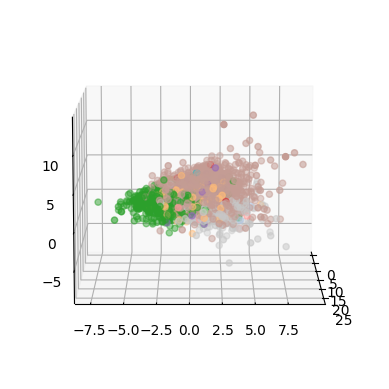

In [45]:
ax = plt.axes(projection ='3d')
ax.scatter(components[:, 0], components[:, 1], components[:, 2], c=characters['cluster'], cmap='tab20')
ax.azim = 0
ax.elev = 10